# Spatial frequency task with Muse

Description...

In [1]:
import os
import sys
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
from mne import Epochs, find_events
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('../muse')
import utils

## Load data into MNE objects

In [2]:
subject = 1
session = 1
raw = utils.load_data('visual/spatial_freq', sfreq=256., 
                      subject_nb=subject, session_nb=session,
                      ch_ind=[0, 1, 2, 3, 4], 
                      replace_ch_names={'Right AUX': 'POz'})

Creating RawArray with float64 data, n_channels=6, n_times=57612
    Range : 0 ... 57611 =      0.000 ...   225.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=57624
    Range : 0 ... 57623 =      0.000 ...   225.090 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=57612
    Range : 0 ... 57611 =      0.000 ...   225.043 secs
Ready.


## Power Spectrum

Effective window size : 8.000 (s)


/usr/local/lib/python3.5/dist-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


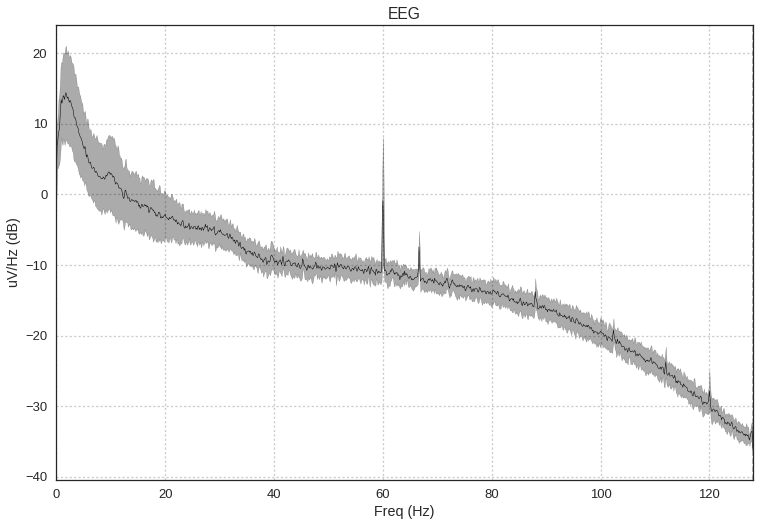

In [3]:
raw.plot_psd(tmax=np.inf);

## ERP analysis

We expect a noticeable ERP response both at the onset and offset of the grating presentation.

In [4]:
# Bandpass filter
filt_raw = raw.copy().filter(1, 30, method='iir')

# Extract epochs
events = find_events(filt_raw)
event_id = {'Low (start)': 1, 'High (start)': 2,
            'Low (end)': 3, 'High (end)': 4}

epochs = Epochs(filt_raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 2, 3, 4, 1])

Setting up band-pass filter from 1 - 30 Hz
480 events found
Events id: [1 2 3 4]


### Onset

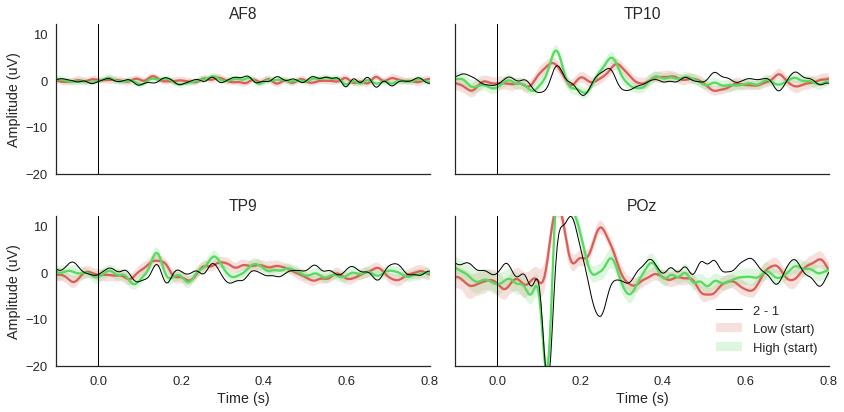

In [5]:
# Time domain visualization
conditions = OrderedDict()
conditions['Low (start)'] = [1]
conditions['High (start)'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2), ylim=(-20, 12))

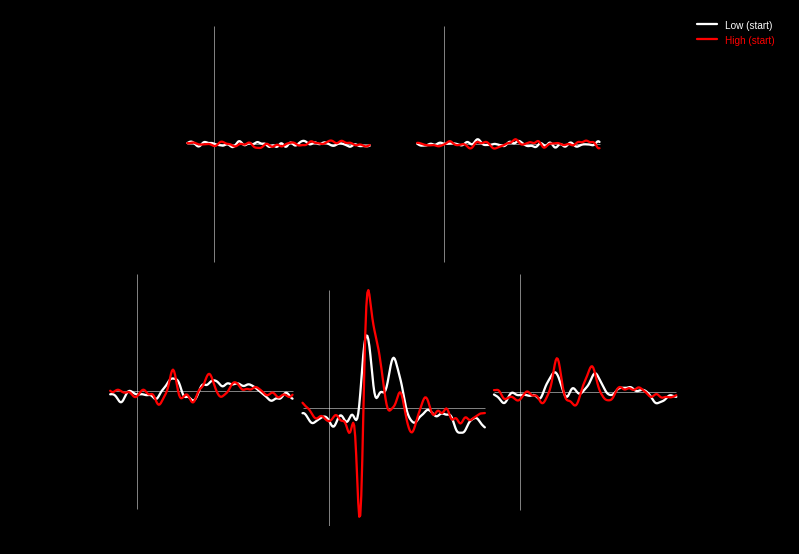

In [6]:
from mne.viz import plot_evoked_topo

h = epochs['High (start)'].copy().crop(-0.1, 0.6).average()
l = epochs['Low (start)'].copy().crop(-0.1, 0.6).average()

plot_evoked_topo([l, h], show=False, color=['w', 'r']);

DESCRIPTION

### Offset (alpha phase reset)

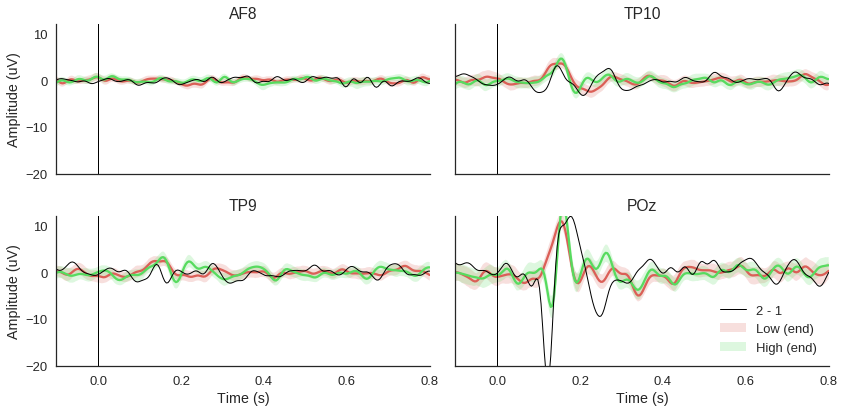

In [7]:
# Time domain visualization
conditions = OrderedDict()
conditions['Low (end)'] = [3]
conditions['High (end)'] = [4]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2), ylim=(-20, 12))

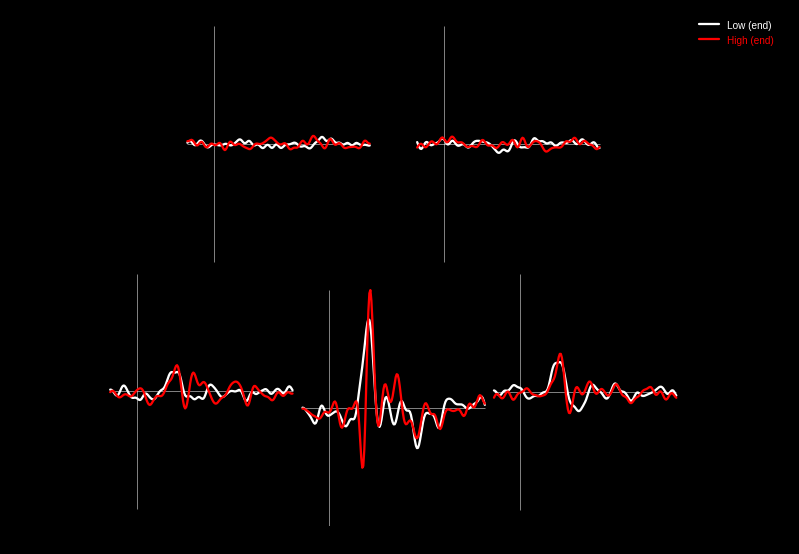

In [8]:
h = epochs['High (end)'].copy().crop(-0.1, 0.6).average()
l = epochs['Low (end)'].copy().crop(-0.1, 0.6).average()

plot_evoked_topo([l, h], show=False, color=['w', 'r']);

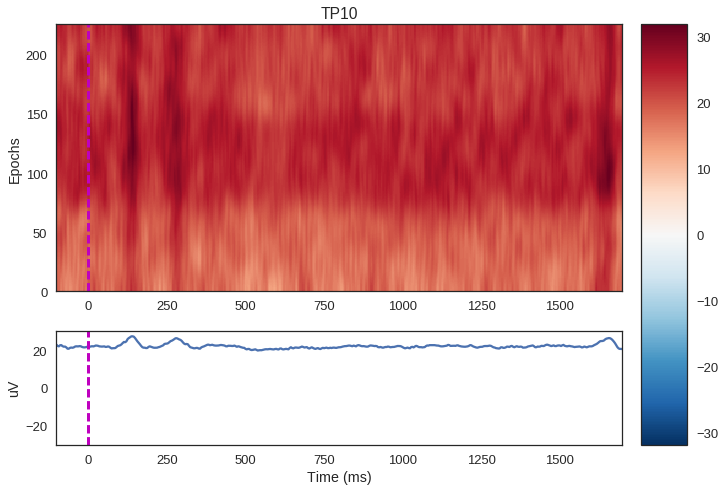

In [18]:
epochs.plot_image(picks=[3], sigma=10)

## Oscillatory activity analysis

Oscillatory activity in the beta and gamma bands is expected during the presentation of the gratings.

In [17]:
# Extract epochs
events = find_events(raw)
event_id = {'Low': 1, 'High': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=1.7, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3, 4])

480 events found
Events id: [1 2 3 4]


### Power spectral density

Effective window size : 4.016 (s)
Effective window size : 4.016 (s)


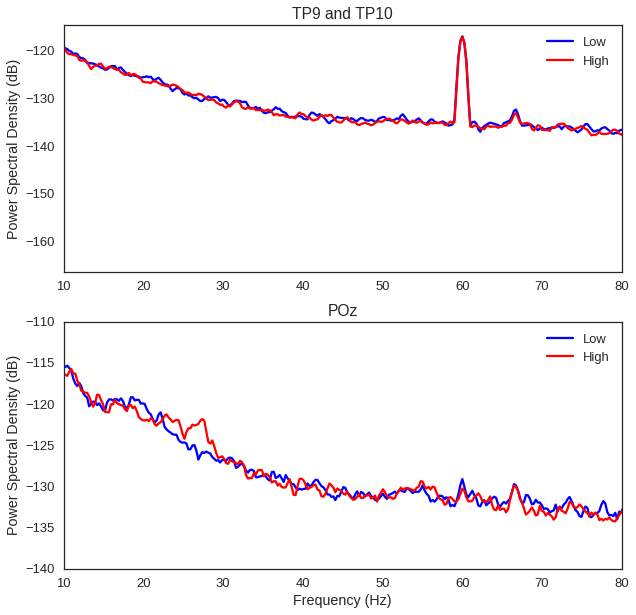

In [21]:
from mne.time_frequency import psd_welch

f, axs = plt.subplots(2, 1, figsize=(10, 10))
psd1, freq1 = psd_welch(epochs['Low'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['High'], n_fft=1028, n_per_seg=256 * 3)
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)

psd2_mean = psd2.mean(0)
psd2_std = psd2.mean(0)

axs[0].plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label='Low')
axs[0].plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label='High')

axs[1].plot(freq1, psd1_mean[4, :], color='b', label='Low')
axs[1].plot(freq2, psd2_mean[4, :], color='r', label='High')

axs[0].set_title('TP9 and TP10')
axs[1].set_title('POz')
axs[0].set_ylabel('Power Spectral Density (dB)')
axs[1].set_ylabel('Power Spectral Density (dB)')
axs[0].set_xlim((10, 80))
axs[1].set_xlim((10, 80))
axs[1].set_ylim((-140, -110))
axs[1].set_xlabel('Frequency (Hz)')
axs[0].legend()
axs[1].legend()

plt.show()

Applying baseline correction (mode: logratio)


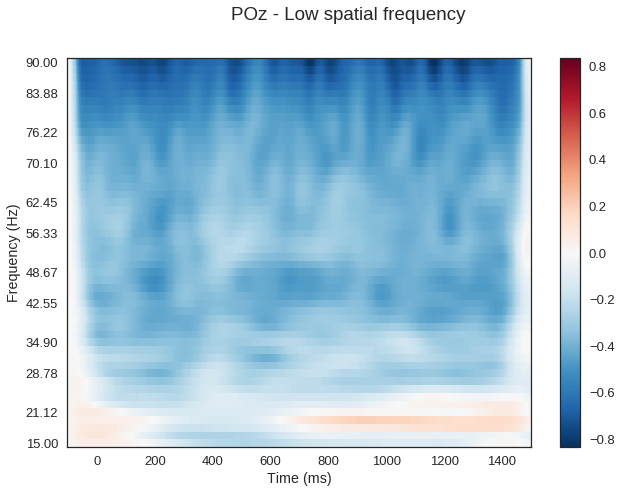

Applying baseline correction (mode: logratio)


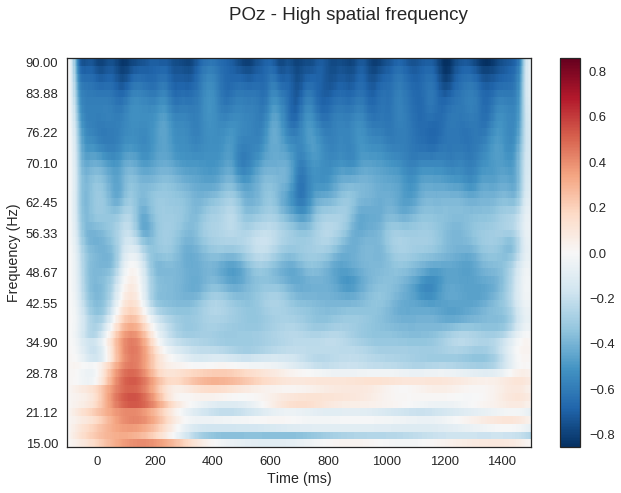

In [12]:
from mne.time_frequency import tfr_morlet

frequencies = np.linspace(15, 90, num=50)
tfr, itc = tfr_morlet(epochs['Low'], freqs=frequencies, 
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - Low spatial frequency');

tfr, itc = tfr_morlet(epochs['High'], freqs=frequencies, 
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - High spatial frequency');

### Importance of different frequencies

We want to identify which EEG frequency bands significantly differ from one spatial frequency to another. To do so, we can train separate classifiers, each one using a different frequency as input. We can then look for bands that led to significantly different than zero performance. These bands are likely to be induced by either a high or low spatial frequency.  

In [13]:
from pyriemann.stats import PermutationDistance, PermutationModel
from pyriemann.estimation import CospCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.classification import TSclassifier, TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from scipy.stats import ttest_1samp


pipe = make_pipeline(CSP(2), StandardScaler(), LogisticRegression())
#pipe = make_pipeline(TangentSpace('logeuclid'), LogisticRegression())

# Extract epochs
events = find_events(raw)
event_id = {'Low': 1, 'High': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=0.5, tmax=1.5, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3, 4])

X = epochs.copy().pick_types(eeg=True, stim=False).get_data()
y = epochs.events[:, 2]

# Compute cospectral covariance matrices (see https://arxiv.org/pdf/0812.0494.pdf, p.17)
fmin = 1.0
fmax = 80
win = 128
cosp = CospCovariances(window=win, overlap=0.99, fmin=fmin, fmax=fmax,
                       fs=epochs.info['sfreq'])
covmats = cosp.fit_transform(1e6 * X)

fr = np.fft.fftfreq(win)[0:int(win/2)] * epochs.info['sfreq']
fr = fr[(fr >= fmin) & (fr <= fmax)]

pv = []
Fv = []
# For each frequency bin, estimate the stats
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

for i in range(covmats.shape[3]):  
    ptest = PermutationModel(50, model=pipe, cv=cv, n_jobs=-1, 
                             scoring='roc_auc')
    p, F = ptest.test(covmats[::1, :, :, i], y[::1]==np.max(y))
    F = F[0]
    print(F, p)
    pv.append(p)
    Fv.append(F)

480 events found
Events id: [1 2 3 4]
Performing permutations : [98.0%]
0.456896551724 0.76
Performing permutations : [98.0%]
0.509885057471 0.42
Performing permutations : [98.0%]
0.52091954023 0.32
Performing permutations : [98.0%]
0.494022988506 0.7
Performing permutations : [98.0%]
0.484137931034 0.66
Performing permutations : [98.0%]
0.531954022989 0.32
Performing permutations : [98.0%]
0.513448275862 0.28
Performing permutations : [98.0%]
0.521494252874 0.26
Performing permutations : [98.0%]
0.620114942529 0.04
Performing permutations : [98.0%]
0.65908045977 0.02
Performing permutations : [98.0%]
0.578390804598 0.08
Performing permutations : [98.0%]
0.538390804598 0.26
Performing permutations : [98.0%]
0.701149425287 0.02
Performing permutations : [98.0%]
0.716896551724 0.02
Performing permutations : [98.0%]
0.45275862069 0.88
Performing permutations : [98.0%]
0.570459770115 0.06
Performing permutations : [98.0%]
0.471954022989 0.72
Performing permutations : [98.0%]
0.535632183908

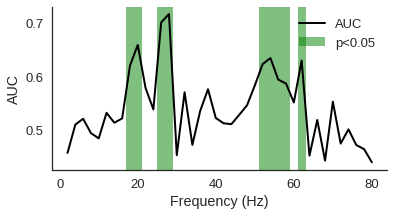

In [14]:
sig = 0.05
fig, axes = plt.subplots(1, 1, figsize=[6,3], sharey=True)

axes.plot(fr, Fv, lw=2, c='k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('AUC')
#plt.ylim(0.4, 0.8)

kk = 0
a = []
while kk<len(pv):
    if pv[kk]<=sig:
        b = kk
        kk += 1
        while kk<len(pv):
            if pv[kk]>sig:
                break
            else:
                kk += 1
        a.append([b, kk - 1])
    else:
        kk +=1
        

st = (fr[1]-fr[0])/2.0
for p in a:
    axes.axvspan(fr[p[0]]-st, fr[p[1]]+st, facecolor='g', alpha=0.5)
plt.legend(['AUC', 'p<%.2f' % sig])
sns.despine();